In [1]:
import pandas as pd
import os


In [2]:
file_path = '/Users/manishparihar/Desktop/CodeBox/ML/ML-NLP-Beginners/USPatient/train.csv'
# Get the absolute path
absolute_path = os.path.abspath(file_path)

In [3]:
if os.path.exists(file_path):
    df = pd.read_csv(file_path)
else:
    print(f"The file '{file_path}' does not exist.")

In [4]:
df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


In [5]:
df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


We can see that in the 36473 rows, there are 733 unique anchors, 106 contexts
and 30000 targets. Some anchors are very common, with "component composite coating" 
for instance appearing 152 times 

In [6]:
df['input'] = 'TEXT1: ' + df.context + '; TEXT2: ' + df.target + '; ANC1: ' +  df.anchor

In [7]:
df.input.head()

0    TEXT1: A47; TEXT2: abatement of pollution; ANC...
1    TEXT1: A47; TEXT2: act of abating; ANC1: abate...
2    TEXT1: A47; TEXT2: active catalyst; ANC1: abat...
3    TEXT1: A47; TEXT2: eliminating process; ANC1: ...
4    TEXT1: A47; TEXT2: forest region; ANC1: abatement
Name: input, dtype: object

Transformers uses a Dataset object for storing a.. well a dataset.

In [8]:
from datasets import Dataset, DatasetDict
ds = Dataset.from_pandas(df)

In [9]:
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

But we cannot pass the texts directly into the model. A deep learning model expects numbers as input, not English sentences
So we need to do two things:
1. Tokenization: Split ech text up into words
2. Numericalization: Convert each word (or token) into a number

The details about how this is done actually depend upon the particular model we choose. So first we will need to pick a model.
There are thousands of models, but a reasonable starting point  for nearly a NLP problem is to use this (replace "small" with "large")
for a slower but more accurate model,  once you have finished exploring.

In [10]:
#model_nm = 'microsoft/deberta-v3-small'
model_nm = "bert-base-uncased"

AutoTokenizer will create a tokenizer appropriate for a given model

In [11]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

Special tokenss have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained

In [12]:
tokz.tokenize("G' day folks, I'm Manish from man.ai!")

['g',
 "'",
 'day',
 'folks',
 ',',
 'i',
 "'",
 'm',
 'mani',
 '##sh',
 'from',
 'man',
 '.',
 'ai',
 '!']

In [13]:
tokz.tokenize("A platypus is an ornithorhynchus anatinus.")

['a',
 'pl',
 '##at',
 '##yp',
 '##us',
 'is',
 'an',
 'or',
 '##ni',
 '##thor',
 '##hy',
 '##nch',
 '##us',
 'ana',
 '##tin',
 '##us',
 '.']

Here's a simple function which tokenizes our inputs:

In [14]:
def tok_func(x): return tokz(x["input"])

In [15]:
toks_ds = ds.map(tok_func, batched=True)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

This adds a new item to our dataset called input_ids. For instance, here is the input and IDs for the first row of our data:

In [16]:
row = toks_ds[0]
row['input'], row['input_ids']

('TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement',
 [101,
  3793,
  2487,
  1024,
  1037,
  22610,
  1025,
  3793,
  2475,
  1024,
  19557,
  18532,
  4765,
  1997,
  10796,
  1025,
  2019,
  2278,
  2487,
  1024,
  19557,
  18532,
  4765,
  102])

So, what are those IDs and where do they come from? The secret is that there's a list called vocab in the tokenizer which contains a unique integer for every possible token string. We can look them up like this, for instance to find the token for the word "of":

In [17]:
tokz.vocab['of']

1997

Looking above at our input IDs, we do indeed see that 1997 appears as expected.

Finally, we need to prepare our labels. Transformers always assumes that your labels has the column name labels, but in our dataset it's currently score. Therefore, we need to rename it:

In [18]:
toks_ds = toks_ds.rename_columns({'score':'labels'})

Now that we've prepared our tokens and labels, we need to create our validation set.

Test and validation sets


In [19]:
eval_df = pd.read_csv('/Users/manishparihar/Desktop/CodeBox/ML/ML-NLP-Beginners/USPatient/test.csv')
eval_df.describe()


,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,el display,inorganic photoconductor drum,G02
freq,1,2,1,3


This is the test set. Possibly the most important idea in machine learning is that of having separate training, validation, and test data sets.

Validation set


To explain the motivation, let's start simple, and imagine we're trying to fit a model where the true relationship is this quadratic:

Unfortunately matplotlib (the most common library for plotting in Python) doesn't come with a way to visualize a function, so we'll write something to do this ourselves:

In [20]:
def f(x): return -3*x**2 + 2*x + 20


In [21]:
import numpy as np, matplotlib.pyplot as plt

def plot_function(f, min=-2.1, max=2.1, color='r'):
    x = np.linspace(min,max, 100)[:,None]
    plt.plot(x, f(x), color)


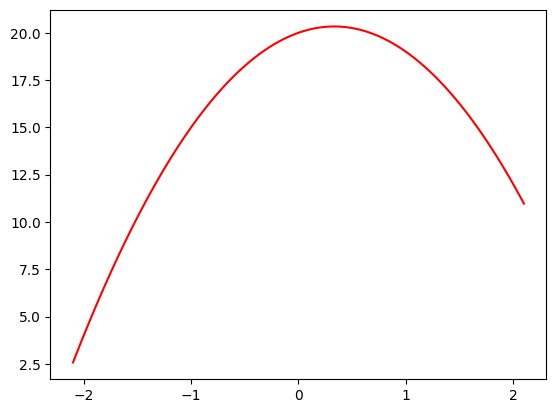

In [22]:
plot_function(f)


In [23]:
from numpy.random import normal,seed,uniform
np.random.seed(42)

Here's a function add_noise that adds some random variation to an array:



In [24]:
def noise(x, scale): return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

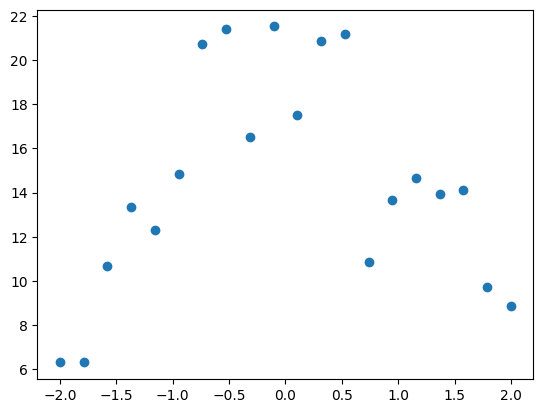

In [25]:
import matplotlib.pyplot as plt

x = np.linspace(-2, 2, num=20)[:,None]
y = add_noise(f(x), 0.2, 1.3)
plt.scatter(x,y);

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def plot_poly(degree):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(x, y)
    plt.scatter(x,y)
    plot_function(model.predict)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


So, what happens if we fit a line (a "degree 1 polynomial") to our measurements?



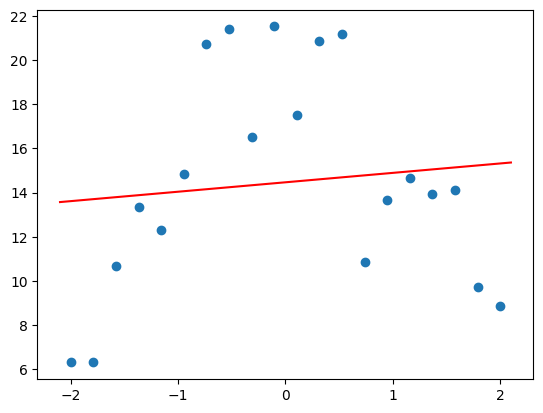

In [27]:
plot_poly(1)


As you see, the points on the red line (the line we fitted) aren't very close at all. This is under-fit -- there's not enough detail in our function to match our data.

And what happens if we fit a degree 10 polynomial to our measurements?

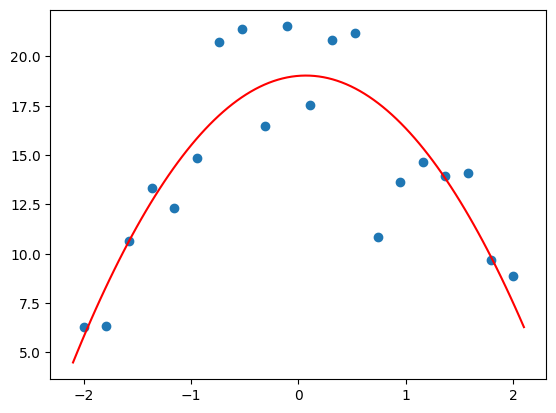

In [28]:
plot_poly(2)

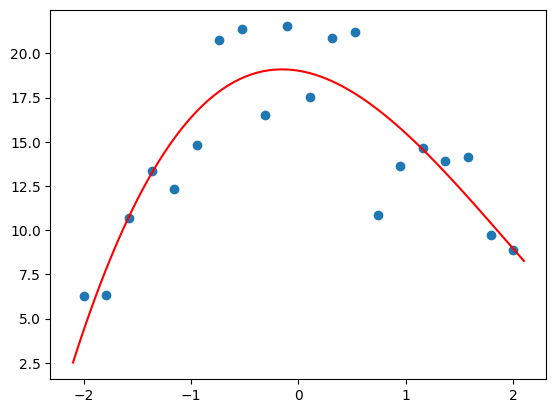

In [29]:
plot_poly(3)

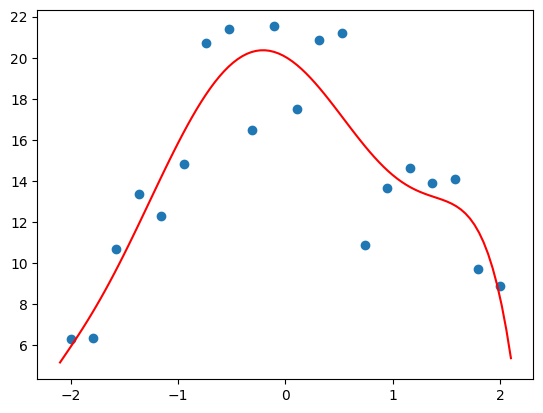

In [30]:
plot_poly(7)

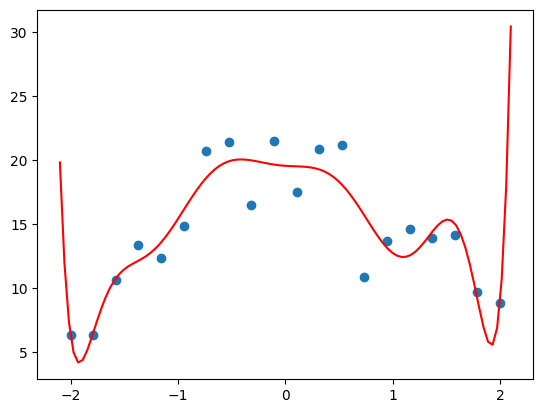

In [31]:
plot_poly(10)

Well now it fits our data better, but it doesn't look like it'll do a great job predicting points other than those we measured -- especially those in earlier or later time periods. This is over-fit -- there's too much detail such that the model fits our points, but not the underlying process we really care about.

Let's try a degree 2 polynomial (a quadratic), and compare it to our "true" function (in blue):

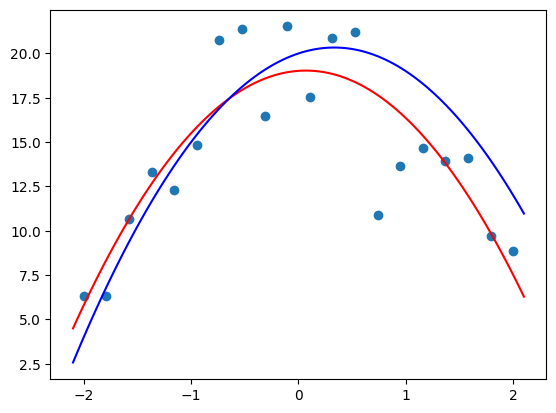

In [32]:
plot_poly(2)
plot_function(f, color='b')

That's not bad at all!

So, how do we recognise whether our models are under-fit, over-fit, or "just right"? We use a validation set. This is a set of data that we "hold out" from training -- we don't let our model see it at all. If you use the fastai library, it automatically creates a validation set for you if you don't have one, and will always report metrics (measurements of the accuracy of a model) using the validation set.

The validation set is only ever used to see how we're doing. It's never used as inputs to training the model.

Transformers uses a DatasetDict for holding your training and validation sets. To create one that contains 25% of our data for the validation set, and 75% for the training set, use train_test_split:

In [33]:
dds = toks_ds.train_test_split(0.25, seed=42)
dds


DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

In practice, a random split like we've used here might not be a good idea -- here's what Dr Rachel Thomas has to say about it:

"One of the most likely culprits for this disconnect between results in development vs results in production is a poorly chosen validation set (or even worse, no validation set at all). Depending on the nature of your data, choosing a validation set can be the most important step. Although sklearn offers a train_test_split method, this method takes a random subset of the data, which is a poor choice for many real-world problems."



So that's the validation set explained, and created. What about the "test set" then -- what's that for?

The test set is yet another dataset that's held out from training. But it's held out from reporting metrics too! The accuracy of your model on the test set is only ever checked after you've completed your entire training process, including trying different models, training methods, data processing, etc.

You see, as you try all these different things, to see their impact on the metrics on the validation set, you might just accidentally find a few things that entirely coincidentally improve your validation set metrics, but aren't really better in practice. Given enough time and experiments, you'll find lots of these coincidental improvements. That means you're actually over-fitting to your validation set!

That's why we keep a test set held back. Kaggle's public leaderboard is like a test set that you can check from time to time. But don't check too often, or you'll be even over-fitting to the test set!

Kaggle has a second test set, which is yet another held-out dataset that's only used at the end of the competition to assess your predictions. That's called the "private leaderboard". Here's a great post about what can happen if you overfit to the public leaderboard.

We'll use eval as our name for the test set, to avoid confusion with the test dataset that was created above.



In [34]:
eval_df['input'] = 'TEXT1: ' + eval_df.context + '; TEXT2: ' + eval_df.target + '; ANC1: ' + eval_df.anchor
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Metrics and correlation
When we're training a model, there will be one or more metrics that we're interested in maximising or minimising. These are the measurements that should, hopefully, represent how well our model will works for us.



it's very straightforward to know what metric to use: Kaggle will tell you! According to this competition's evaluation page, "submissions are evaluated on the Pearson correlation coefficient between the predicted and actual similarity scores." This coefficient is usually abbreviated using the single letter r. It is the most widely used measure of the degree of relationship between two variables.

r can vary between -1, which means perfect inverse correlation, and +1, which means perfect positive correlation. The mathematical formula for it is much less important than getting a good intuition for what the different values look like.

In [35]:
def corr_d(eval_pred): return {'pearson': corr(*eval_pred)}


Training our model

To train a model in Transformers we'll need this:

In [36]:
from transformers import TrainingArguments,Trainer

In [37]:
bs = 128
epochs = 4
#We pick a batch size that fits our GPU, and small number of epochs so we can run experiments quickly:

In [38]:
lr = 8e-5
#The most important hyperparameter is the learning rate. fastai provides a learning rate finder to help you figure this out, but Transformers doesn't, so you'll just have to use trial and error. The idea is to find the largest value you can, but which doesn't result in training failing.

Transformers uses the TrainingArguments class to set up arguments. Don't worry too much about the values we're using here -- they should generally work fine in most cases. It's just the 3 parameters above that you may need to change for different models.

In [40]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=False,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none')


In [41]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz, compute_metrics=corr_d)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We can now create our model, and Trainer, which is a class which combines the data and model together (just like Learner in fastai):

In [42]:
trainer.train();

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss



KeyboardInterrupt

